#FGSM PREPROCESSING
## GTSRB_proprocessed 이미지 만든 코드입니다.
* 32 by 32로 통일
* {data}_preprocessed 폴더에 각각 저장


# 1. Data Mount & Import

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as img
import keras
import os
from PIL import Image
import natsort
import io
import cv2

In [3]:
cd drive/MyDrive/[한이음] 적대적 AI 공격에 대한 인공지능 보안기술 연구/3. 소스코드/GTSRB

/content/drive/MyDrive/[한이음] 적대적 AI 공격에 대한 인공지능 보안기술 연구/3. 소스코드/GTSRB


# 2. Data Load & Preprocessing

In [4]:
metainfo = pd.read_csv("Meta.csv")
traininfo = pd.read_csv("Train.csv")
testinfo = pd.read_csv("Test.csv")

In [5]:
# 43개 클래스 모두 사용
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

Image Shape: (54, 53, 3)


Text(0.5, 1.0, 'imgRGB')

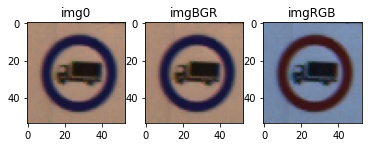

In [6]:
## 일단 이미지 하나만 읽어보기
img0 = cv2.imread("Test/00000.png")
print("Image Shape:", img0.shape) # (54, 53, 3)
plt.subplot(131)
plt.imshow(img0)
plt.title('img0')

# OpenCV : B-G-R, matplotlib : R-G-B => BGR을 RGB로 바꿔줘야 사진이 제대로 표시됨
imgBGR = img0
imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)

plt.subplot(132)
plt.imshow(imgBGR)
plt.title('imgBGR')

plt.subplot(133)
plt.imshow(imgRGB)
plt.title('imgRGB')

Text(0.5, 1.0, 'imgBGRn')

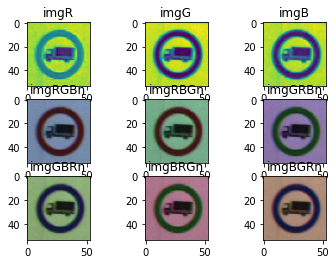

In [7]:
## R/G/B plane 각각 plot 확인
imgR = imgRGB[:,:,0]
imgG = imgRGB[:,:,1]
imgB = imgRGB[:,:,2]

## RGB 재합성
imgRGBn = np.dstack((imgR,imgG,imgB))
imgRBGn = np.dstack((imgR,imgB,imgG))
imgGRBn = np.dstack((imgG,imgR,imgB))
imgGBRn = np.dstack((imgG,imgB,imgR))
imgBRGn = np.dstack((imgB,imgR,imgG))
imgBGRn = np.dstack((imgB,imgG,imgR))

## plot으로 확인
# R/G/B 각각
plt.subplot(331);plt.imshow(imgR);plt.title('imgR')
plt.subplot(332);plt.imshow(imgG);plt.title('imgG')
plt.subplot(333);plt.imshow(imgB);plt.title('imgB')
# RGB 재합성
plt.subplot(334);plt.imshow(imgRGBn);plt.title('imgRGBn')
plt.subplot(335);plt.imshow(imgRBGn);plt.title('imgRBGn')
plt.subplot(336);plt.imshow(imgGRBn);plt.title('imgGRBn')
plt.subplot(337);plt.imshow(imgGBRn);plt.title('imgGBRn')
plt.subplot(338);plt.imshow(imgBRGn);plt.title('imgBRGn')
plt.subplot(339);plt.imshow(imgBGRn);plt.title('imgBGRn')

In [8]:
# ### PREPROCESSING : 32 by 32 데이터셋 ==> 성능의 문제로...
# y_meta = list(range(43))
# y_train = traininfo.ClassId
# y_test = testinfo.ClassId
# X_meta = np.zeros([32,32,3,len(y_meta)])
# X_train = np.zeros([32,32,3,len(y_train)])
# X_test = np.zeros([32,32,3,len(y_test)])

# datanames = ["Meta", "Test"] # Train은 아래에 따로 작성하였음

# for dataname in datanames:
#   filenames = natsort.natsorted(os.listdir(dataname))

#   # (1)1:1cut (2)64by64resize (3)dataset (4)드라이브저장
#   for i in range(len(filenames)):
#     filepath = dataname + "/" + filenames[i]
#     imgBGR = cv2.imread(filepath)
#     imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB) # 원본 RGB 이미지
  
#     # (1)1:1cut
#     imgsize = imgRGB.shape
#     imgsquare = imgRGB
#     if (imgsize[0] == imgsize[1]): # 이미 1:1이라면 그대로 사용
#       pass 
#     elif (imgsize[0] != imgsize[1]): # 1:1로 잘라서 사용 (가운데에 맞춰 자름)
#       lendif = imgsize[0] - imgsize[1] # 가로세로 길이 차이
#       if (lendif < 0): # 가로가 긴 이미지 : 세로 기준
#         midcut1 = abs(lendif)//2 # 몫
#         imgsquare = imgRGB[:,midcut1:midcut1+imgsize[0]]
#         # # 어떤 이미지가 cut 되었는지 확인
#         # print(f"{i} 가로 cut : {imgsize} -> {imgsquare.shape}")
#       elif (lendif > 0): # 세로가 긴 이미지 : 가로 기준
#         midcut2 = abs(lendif)//2 # 몫
#         imgsquare = imgRGB[midcut2:midcut2+imgsize[1],:]
#         # # 어떤 이미지가 cut 되었는지 확인
#         # print(f"{i} 세로 cut : {imgsize} -> {imgsquare.shape}")

#     # (2)64by64resize
#     resrat = 32/imgsquare.shape[0]
#     imgresize = cv2.resize(imgsquare, dsize=(0,0), fx=resrat, fy=resrat, interpolation=cv2.INTER_LINEAR)

#     # (3)dataset
#     if dataname == "Meta":
#       X_meta[:,:,:,i] = imgresize
#     elif dataname == "Test":
#       X_test[:,:,:,i] = imgresize

#     # (4)드라이브저장
#     fname = "./" + dataname + "_preprocessed/" + str(i) + ".png"
#     imgcv2 = imgresize[:,:,::-1] # cv2 BGR 순서 맞추기
#     cv2.imwrite(fname, imgcv2)

# # X_train =====================================================================#
# dirnames = natsort.natsorted(os.listdir("Train"))

# totfnum = 0
# for dirname in dirnames:
#   fpath = "./Train/" + dirname

#   filenames = natsort.natsorted(os.listdir(fpath))

#   # (1)1:1cut (2)64by64resize (3)dataset (4)드라이브저장
#   for i in range(len(filenames)):
#     filepath = "Train/" + dirname + "/" + filenames[i]
#     imgBGR = cv2.imread(filepath)
#     imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB) # 원본 RGB 이미지
  
#     # (1)1:1cut
#     imgsize = imgRGB.shape
#     imgsquare = imgRGB
#     if (imgsize[0] == imgsize[1]): # 이미 1:1이라면 그대로 사용
#       pass 
#     elif (imgsize[0] != imgsize[1]): # 1:1로 잘라서 사용 (가운데에 맞춰 자름)
#       lendif = imgsize[0] - imgsize[1] # 가로세로 길이 차이
#       if (lendif < 0): # 가로가 긴 이미지 : 세로 기준
#         midcut1 = abs(lendif)//2 # 몫
#         imgsquare = imgRGB[:,midcut1:midcut1+imgsize[0]]
#         # # 어떤 이미지가 cut 되었는지 확인
#         # print(f"{i} 가로 cut : {imgsize} -> {imgsquare.shape}")
#       elif (lendif > 0): # 세로가 긴 이미지 : 가로 기준
#         midcut2 = abs(lendif)//2 # 몫
#         imgsquare = imgRGB[midcut2:midcut2+imgsize[1],:]
#         # # 어떤 이미지가 cut 되었는지 확인
#         # print(f"{i} 세로 cut : {imgsize} -> {imgsquare.shape}")

#     # (2)64by64resize
#     resrat = 32/imgsquare.shape[0]
#     imgresize = cv2.resize(imgsquare, dsize=(0,0), fx=resrat, fy=resrat, interpolation=cv2.INTER_LINEAR)

#     # (3)dataset
#     X_train[:,:,:,totfnum] = imgresize
#     totfnum += 1

#     # (4)드라이브저장
#     fname = "./Train_preprocessed/" + dirname + "_" + str(i) + ".png"
#     imgcv2 = imgresize[:,:,::-1] # cv2 BGR 순서 맞추기
#     cv2.imwrite(fname, imgcv2)

#     print(dirname, ":", i)

In [9]:
# PREPROCESSING
imgs_path = ["Meta", "Train", "Test"]
y_meta_l = []
y_train_l = []
y_test_l = []
X_meta_l = []
X_train_l = []
X_test_l = []

# Meta
i = 0
for img in natsort.natsorted(os.listdir(imgs_path[0])):
  print("Meta - img : ", img)
  ii = Image.open(imgs_path[0] +'/'+ img)
  ii = ii.resize((32,32))
  ii = np.array(ii)
  X_meta_l.append(ii)
  y_meta_l.append(i)
  fname = "./Meta_preprocessed/meta_" + str(i) + ".png"
  ii[:,:,0:3] = ii[:,:,3:0:-1]
  cv2.imwrite(fname,ii)
  i += 1

# Train
for i in range(43):
  img_path = os.path.join(imgs_path[1], str(i))
  print("Train - dir :", i)
  j = 0
  for img in natsort.natsorted(os.listdir(img_path)):
    ii = Image.open(img_path +'/'+ img)
    ii = ii.resize((32,32))
    ii = np.array(ii)
    X_train_l.append(ii)
    y_train_l.append(i)
    fname = "./Train_preprocessed/train_" + str(i) + "_" + str(j) + ".png"
    ii = ii[:,:,::-1]
    cv2.imwrite(fname,ii)
    j += 1
# Test
i = 0
for img in natsort.natsorted(os.listdir(imgs_path[2])):
  print("Test - img : ", img)
  ii = Image.open(imgs_path[2] +'/'+ img)
  ii = ii.resize((32,32))
  ii = np.array(ii)
  X_test_l.append(ii)
  y_test_l.append(i)
  fname = "./Test_preprocessed/test_" + str(i) + ".png"
  ii = ii[:,:,::-1]
  cv2.imwrite(fname,ii)
  i += 1

# ndarray
y_meta = np.array(y_meta_l)
y_train = np.array(y_train_l)
y_test = np.array(y_test_l)
X_meta = np.array(X_meta_l)
X_train = np.array(X_train_l)
X_test = np.array(X_test_l)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Test - img :  07630.png
Test - img :  07631.png
Test - img :  07632.png
Test - img :  07633.png
Test - img :  07634.png
Test - img :  07635.png
Test - img :  07636.png
Test - img :  07637.png
Test - img :  07638.png
Test - img :  07639.png
Test - img :  07640.png
Test - img :  07641.png
Test - img :  07642.png
Test - img :  07643.png
Test - img :  07644.png
Test - img :  07645.png
Test - img :  07646.png
Test - img :  07647.png
Test - img :  07648.png
Test - img :  07649.png
Test - img :  07650.png
Test - img :  07651.png
Test - img :  07652.png
Test - img :  07653.png
Test - img :  07654.png
Test - img :  07655.png
Test - img :  07656.png
Test - img :  07657.png
Test - img :  07658.png
Test - img :  07659.png
Test - img :  07660.png
Test - img :  07661.png
Test - img :  07662.png
Test - img :  07663.png
Test - img :  07664.png
Test - img :  07665.png
Test - img :  07666.png
Test - img :  07667.png
Test - img :  07668.png
Test - img :  07669.png
Test